## Transfer Learning

In the context of deep learning, transfer learning is the process of using a pre-trained neural network as the starting point for a new task, rather than training a neural network from scratch. The idea is to use knowledge learned from one task to improve performance on a new, related task.

The pre-trained neural network is first trained on a large dataset, and then the weights and biases of the network are used as a starting point for a new task. The pre-trained network is fine-tuned on a smaller dataset specific to the new task. This process can significantly reduce the amount of data and computational resources required to train a new deep learning model, while potentially also improving its performance.

Transfer learning is widely used in computer vision and natural language processing tasks. It shines, and shows its value for On Convolutional Neural Networks and Transformers.

This notebook shows how to transfer learning can run on a toy model. We use a dense (fully connected) feed-forward neural network with four layers. Generally speaking, such shallow and dense neural networks are not the best candidates for transfer learning.


The main takeaway from this notebook is:
1. Know how to run transfer learning in Keras


This notebook is based on the [notebook](https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb) associated with Geron chapter 11. It is presented here with modifications in accordance with the Apache 2.0 license.

## The Data - Fashion MNIST
The data:
https://keras.io/api/datasets/fashion_mnist/

Fashion-MNIST is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST.

The classes are:

Label |	Description
--- | ---
0|	T-shirt/top
1|	Trouser
2|	Pullover
3|	Dress
4|	Coat
5|	Sandal
6|	Shirt
7|	Sneaker
8|	Bag
9|	Ankle boot

In [1]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
import matplotlib.pyplot as plt

## Get the Data

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
# split the 60,000 training images into 55,000 training images and 5,000 validation images
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

## Explore the Data

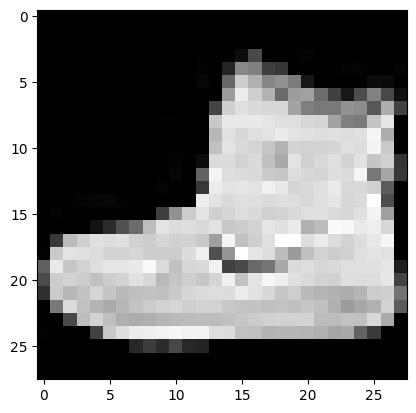

In [5]:
plt.imshow(X_train[0], cmap='gray')

In [6]:
y_train[0]

9

In [7]:
class_names[y_train[0]]

'Ankle boot'

In [8]:
print(type(X_train[0,0,0]))

<class 'numpy.uint8'>


## Preprocess the Data
Notice that unlike the previous notebook, where MNIST was used, in this notebook we don't flatten the images to vectors at the preprocess stage.
Instead, we flatten it as the first stage of the model.
By the way, we could also add the preprocessing below to be part of the model. This is useful for stages that we expect to _always_ be required when running the model.

Notice that the mean and standard deviation are calulated only over the training set, and then used for all datasets, including the validation and test sets. Can you say why?

In [9]:
# scale the values to 0 - 1 by using min-max normalization
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [10]:
# normalize the data such that each feature (each pixel) has a mean of zero
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Split the Data to Demonstrate Transfer-Learning

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for **T-shirts/tops** and **pullovers** (classes **0** and **2**).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [11]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

## Define the Model

In [12]:
tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 4s 3ms/step - loss: 1.1787 - accuracy: 0.6364 - val_loss: 0.6959 - val_accuracy: 0.7904
Epoch 2/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.5907 - accuracy: 0.8157 - val_loss: 0.5118 - val_accuracy: 0.8348
Epoch 3/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4739 - accuracy: 0.8487 - val_loss: 0.4418 - val_accuracy: 0.8501
Epoch 4/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4172 - accuracy: 0.8636 - val_loss: 0.3986 - val_accuracy: 0.8644
Epoch 5/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3819 - accuracy: 0.8735 - val_loss: 0.3723 - val_accuracy: 0.8699
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3575 - accuracy: 0.8790 - val_loss: 0.3519 - val_accuracy: 0.8769
Epoch 7/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3402 - accuracy: 0.8841 - val_loss: 0.3383 - val_accuracy:

INFO:tensorflow:Assets written to: my_model_A\assets


INFO:tensorflow:Assets written to: my_model_A\assets


In [13]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 39ms/step - loss: 0.8813 - accuracy: 0.1500 - val_loss: 0.8283 - val_accuracy: 0.1780
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.8425 - accuracy: 0.1650 - val_loss: 0.7982 - val_accuracy: 0.1978
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.8090 - accuracy: 0.2000 - val_loss: 0.7716 - val_accuracy: 0.2305
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.7766 - accuracy: 0.2050 - val_loss: 0.7503 - val_accuracy: 0.2928
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.7536 - accuracy: 0.2750 - val_loss: 0.7295 - val_accuracy: 0.3680
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.7315 - accuracy: 0.3850 - val_loss: 0.7110 - val_accuracy: 0.4392
Epoch 7/20
7/7 [==============================] - 0s 15ms/step - loss: 0.7120 - accuracy: 0.4450 - val_loss: 0.6939 - val_accuracy: 0.5163
Epoch 8/20
7/7 [===========

In [14]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.8825


[0.555753231048584, 0.8824999928474426]

Now let's try reusing the pretrained model A.

In [15]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [16]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [17]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 43ms/step - loss: 2.3954 - accuracy: 0.4450 - val_loss: 1.7080 - val_accuracy: 0.4847
Epoch 2/4
7/7 [==============================] - 0s 15ms/step - loss: 1.5009 - accuracy: 0.4450 - val_loss: 1.0124 - val_accuracy: 0.4906
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.9050 - accuracy: 0.4450 - val_loss: 0.7103 - val_accuracy: 0.5272
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.6951 - accuracy: 0.5600 - val_loss: 0.6753 - val_accuracy: 0.5757
Epoch 1/16
7/7 [==============================] - 1s 36ms/step - loss: 0.6495 - accuracy: 0.6600 - val_loss: 0.6274 - val_accuracy: 0.6261
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.6054 - accuracy: 0.7250 - val_loss: 0.5759 - val_accuracy: 0.7577
Epoch 3/16
7/7 [==============================] - 0s 14ms/step - loss: 0.5564 - accuracy: 0.7950 - val_loss: 0.5517 - val_accuracy: 0.7784
Epoch 4/16
7/7 [===============

In [18]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.8825


[0.555753231048584, 0.8824999928474426]

In [19]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.3262 - accuracy: 0.9370


[0.3261830806732178, 0.9369999766349792]